# Posture Detector Analysis

EDA and supervised classifier modelling of posture.

People in exaggerated and non-exaggerated postures where recorded
with 7 variables, angle and gravity for each orthogonal axis and
a flex sensor that bends with the body changing its resistance.

This notebook contains feature understanding, model selecting,
model hyperparametrization, and  model validation.

## Setup

In [4]:
%load_ext autoreload
%autoreload 2

In [63]:
import sklearn.pipeline

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import optuna
import pickle

import sklearn
from sklearn import model_selection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, \
    QuadraticDiscriminantAnalysis
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split as tts
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import yellowbrick

import posture_detector
from posture_detector.constants import columns

In [6]:
figure_path = '../images/'

In [7]:
optuna.logging.set_verbosity(optuna.logging.ERROR)

# Load and parse dataset

In [8]:
data_location = 'data/raw/datalog_at_2021-07-04_19_07_28.038692'

In [9]:
df_raw = pd.read_csv('../' + data_location)
df_raw.head()

,Ax,Ay,Az,Temperature,gx,gy,gz,FlexSensor,Label
0,-0.187500,-0.883301,-0.452393,27.4947,1.90840,1.625950,-13.87790,562,NaN
1,-0.286377,-0.917725,-0.354248,27.4947,-4.64122,-1.694660,-4.77099,561,NaN
2,-0.350342,-0.951172,-0.354492,27.4947,-5.37405,-0.496183,1.30534,561,NaN
3,-0.303711,-0.922119,-0.364258,27.5888,-3.95420,0.015267,0.51145,561,NaN
4,-0.299561,-0.919678,-0.356934,27.4947,-2.96947,1.145040,5.68702,561,NaN


# Prepared Dataset

In [10]:
df = posture_detector.data.parse_dataset(df_raw)
df.head()


,Ax,Ay,Az,gx,gy,gz,FlexSensor,Label
982,-0.610840,-0.723877,-0.347656,-0.954198,2.297710,1.854960,573,0
983,-0.630127,-0.722168,-0.338867,-2.595420,1.358780,0.793893,572,0
984,-0.632568,-0.718506,-0.345459,-3.633590,0.656489,3.091600,572,0
985,-0.637451,-0.713135,-0.352051,-3.503820,1.648850,3.587790,574,0
986,-0.622559,-0.710938,-0.329834,-4.610690,-0.931298,2.435110,574,0


In [11]:
X, y = posture_detector.data.train_test.split_record_data(df.drop(columns=['gx', 'gy', 'gz']))
X_train, X_validation ,y_train, y_validation = sklearn.model_selection.train_test_split(X, y)

# EDA
Discover and understand the features

## How Variables differ over the labels?

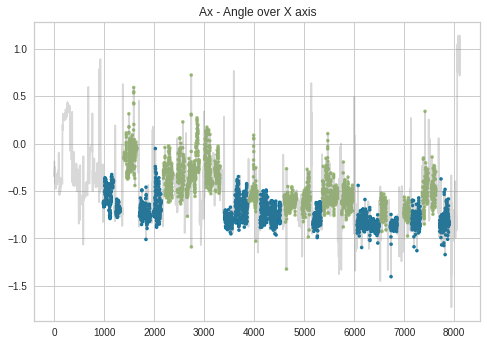

In [12]:
plt.title('Ax - Angle over X axis')
posture_detector.viz.plot_positions_from_df(
    df_raw, ['e', 'c'], columns.Record.Ax
)


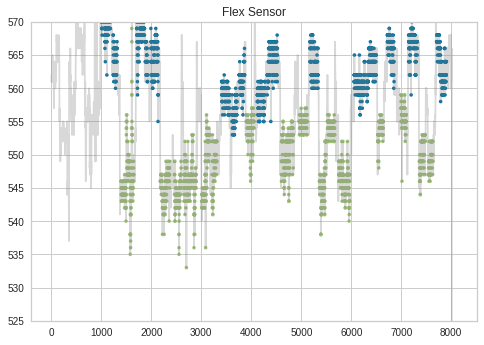

In [13]:
plt.title('Flex Sensor')
plt.ylim((525, 570))
posture_detector.viz.plot_positions_from_df(
    df_raw, ['e', 'c'], columns.Record.Flex
)

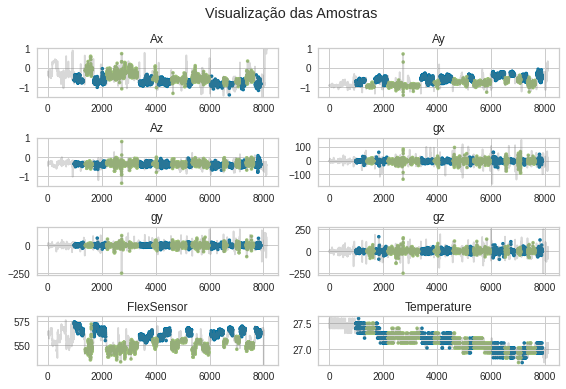

In [58]:
figure, axis = plt.subplots(4, 2)
cols = [
    columns.Record.Ax,
    columns.Record.Ay,
    columns.Record.Az,
    columns.Record.Gx,
    columns.Record.Gy,
    columns.Record.Gz,
    columns.Record.Flex,
    columns.Record.T,
]
figure.tight_layout(h_pad=2)
for ax, col in zip(axis.flat, cols):
    posture_detector.viz.plot_positions_from_df(
        df_raw, ['e', 'c'], col, ax
    )
    if df_raw[col].max() < 50 and col != 'Temperature':
        ax.set_ylim((-1.5, 1))
    if col == columns.Record.Flex:
        ax.set_ylim((530, 580))
    ax.set_title(col)
plt.subplots_adjust(top=0.875)
plt.suptitle('Visualização das Amostras')
plt.savefig(figure_path+'visualizacao_das_amostras.png')
plt.show()

It looks like the Ay variable is not varying between
the classes, at least not as much as Ax and FlexSensor

The temperature increase over time makes no sense so
it should be dropped.

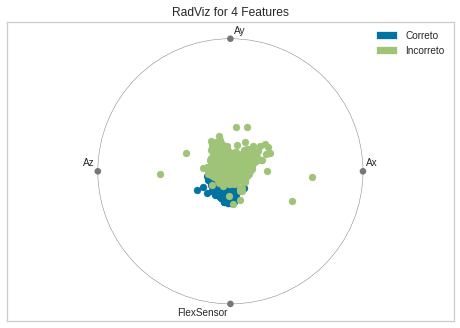

In [15]:
posture_detector.viz.plot_radial_feature_comparisons(X, y )

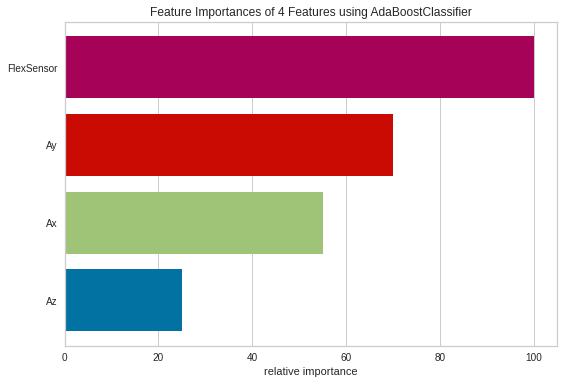

In [16]:
posture_detector.viz.plot_feature_importances(X, y)

# Selecting Models

## List Candidates

In [17]:
lda_model = LinearDiscriminantAnalysis(
    solver='lsqr'
)

In [18]:
qda = QuadraticDiscriminantAnalysis()

In [19]:
ridge_model = RidgeClassifier()

In [20]:
kn_model = KNeighborsClassifier()

In [21]:
# gpc_model = GaussianProcessClassifier()

In [22]:
ada_model = AdaBoostClassifier()

In [23]:
forest_clf = RandomForestClassifier()

In [24]:
dtree_clf = DecisionTreeClassifier()

In [64]:
logit = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression())
])

## Evaluating Models

In [65]:
model_register = [
    ('lda', lda_model),
    ('ridge', ridge_model),
    ('qda', qda),
    ('kn', kn_model),
    ('forest_clf', forest_clf),
    ('ada_model', ada_model),
    ('logit', logit),
    # ('dtree', dtree_clf)
    # ('dtree', dtree_clf)
    # ('gpc_model', gpc_model),
]

In [66]:
df_compare = posture_detector.models.tasks.get_model_comparisons_dataframe(
    model_register,
    X_train, y_train,
    scoring=('accuracy', 'recall', 'f1', 'precision'),
    cv=3,
)
df_compare

accuracy          recall              f1         precision        
              train    test   train    test   train    test     train    test
lda          0.9662  0.9658  0.9672  0.9686  0.9660  0.9658    0.9669  0.9681
ridge        0.9665  0.9658  0.9674  0.9691  0.9660  0.9658    0.9669  0.9681
qda          0.9569  0.9655  0.9585  0.9516  0.9567  0.9663    0.9583  0.9504
kn           0.9747  0.9809  0.9756  0.9703  0.9650  0.9707    0.9662  0.9617
forest_clf   1.0000  1.0000  1.0000  1.0000  0.9660  0.9731    0.9672  0.9613
ada_model    0.9758  0.9875  0.9768  0.9663  0.9690  0.9814    0.9702  0.9593
logit        0.9681  0.9765  0.9693  0.9622  0.9657  0.9741    0.9670  0.9600

In [29]:
df_compare.to_clipboard()

The comparisons show that lda and ridge have the best results because
they perform better in test metrics (even if forest and decision tree
perform better at training which indicates overfit.

Also, lda and ridge have very close train test values indicating good
bias variance tradeoff.

That's surprising since they're the simplest model which make
them ever better.

# Model Hyperparametrization

# Ridge Model

In [30]:
def objective(trial: optuna.trial.Trial):
    alpha = trial.suggest_loguniform('alpha', 1e-6, 1e+6),
    solver = trial.suggest_categorical('solver', ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'])

    ridge_clf = RidgeClassifier(
        alpha = alpha,
        solver = solver,
    )
    result = model_selection.cross_validate(
        ridge_clf,
        X_train, y_train,
        cv=5,
        scoring='recall'
    )
    return np.mean(result['test_score'])

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500, n_jobs=12, show_progress_bar=True)

/home/gabriel/dev/posture_detector/venv/lib/python3.9/site-packages/optuna/study.py:394: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(
/home/gabriel/dev/posture_detector/venv/lib/python3.9/site-packages/optuna/_optimize.py:79: UserWarning: Progress bar only supports serial execution (`n_jobs=1`).
  warnings.warn("Progress bar only supports serial execution (`n_jobs=1`).")


In [31]:
print(f'study.best_params: {study.best_params}')
print(f'study.best_value: {study.best_value}')

study.best_params: {'alpha': 575302.2868900361, 'solver': 'saga'}
study.best_value: 0.9937131549655771


In [32]:
hyper_ridge_clf = RidgeClassifier(
        alpha=study.best_params['alpha'],
        solver=study.best_params['solver'],
    )
res = posture_detector.models.tasks.get_model_comparisons_dataframe(
    [('hyper_ridge_clf', hyper_ridge_clf)],
    X_train, y_train,
    scoring=('recall', 'accuracy', 'f1', 'precision'),
)
res.T

hyper_ridge_clf
recall    train           0.9937
          test            0.9672
accuracy  train           0.9688
          test            0.9452
f1        train           0.9937
          test            0.9672
precision train           0.9689
          test            0.9453

# LDA Model

In [33]:
def objective(trial: optuna.trial.Trial):
    n_components = trial.suggest_int('n_components', 1, 7)
    solver = trial.suggest_categorical('solver', ['svd', 'lsqr', 'eigen'])
    # shrinkage = trial.suggest_categorical('shrinkage', [None, 1, .25, .5, .75, .1])
    lda_clf = LinearDiscriminantAnalysis(
        n_components=n_components,
        solver=solver,
        # shrinkage=shrinkage,
    )
    result = model_selection.cross_validate(
        lda_clf,
        X_train, y_train,
        cv=5,
        n_jobs=5,
        scoring='f1'
    )
    return np.mean(result['test_score'])

study = optuna.create_study()
study.optimize(objective, n_trials=200)


In [34]:
print(f'study.best_params: {study.best_params}')
print(f'study.best_value: {study.best_value}')

study.best_params: {'n_components': 1, 'solver': 'lsqr'}
study.best_value: 0.9682279674708557


In [35]:
hyper_lda_clf = LinearDiscriminantAnalysis(
        n_components=study.best_params['n_components'],
        solver=study.best_params['solver'],
        # shrinkage=study.best_params['shrinkage'],
    )
res = posture_detector.models.tasks.get_model_comparisons_dataframe(
    [('hyper_lda_clf', hyper_lda_clf)],
    X_train, y_train,
    scoring=('recall', 'accuracy', 'f1', 'precision')
)
res.T

hyper_lda_clf
recall    train         0.9660
          test          0.9673
accuracy  train         0.9681
          test          0.9703
f1        train         0.9659
          test          0.9675
precision train         0.9682
          test          0.9707

## Comparing Both

In [36]:
model_register = [
    ('hyper_ridge_clf', hyper_ridge_clf),
    ('hyper_lda_clf', hyper_lda_clf),
]
posture_detector.models.tasks.get_model_comparisons_dataframe(
    model_register,
    X, y,
    scoring=('recall', 'accuracy', 'f1', 'precision'),
    decimals=10
)

recall            accuracy                  f1            \
                    train      test     train      test     train      test   
hyper_ridge_clf  0.979422  0.969367  0.970208  0.961166  0.979419  0.969365   
hyper_lda_clf    0.968144  0.968208  0.968767  0.969392  0.967945  0.967956   

                precision            
                    train      test  
hyper_ridge_clf  0.970206  0.961184  
hyper_lda_clf    0.968522  0.969189

In [46]:
make_it_a_pca_pipe = lambda m, n=None: sklearn.pipeline.Pipeline([
    ('pca', sklearn.decomposition.PCA(n_components=n or 5)),
    ('model', m)
])

model_register = [
    ('pca_hyper_ridge_clf', make_it_a_pca_pipe(hyper_ridge_clf)),
    ('pca_hyper_lda_clf', make_it_a_pca_pipe(hyper_lda_clf)),
]
posture_detector.models.tasks.get_model_comparisons_dataframe(
    model_register,
    X, y,
    scoring=('recall', 'accuracy', 'f1', 'precision'),
    decimals=10
)

/home/gabriel/dev/posture_detector/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/gabriel/dev/posture_detector/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/gabriel/dev/posture_detector/venv/lib/python3.9/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/gabriel/dev/posture_detector/venv/lib/python3.9/site-packages/sklearn/pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/home/gabriel/dev/posture_detector/venv/lib/python3.9/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/gabriel/dev/posture_detector/

recall      accuracy         f1      precision     
                     train test    train test train test     train test
pca_hyper_ridge_clf    NaN  NaN      NaN  NaN   NaN  NaN       NaN  NaN
pca_hyper_lda_clf      NaN  NaN      NaN  NaN   NaN  NaN       NaN  NaN

Seriously, are they equal? How the hell?

## Confusion Matrices

In [47]:
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2)


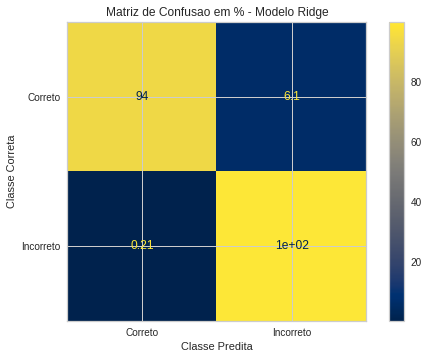

In [48]:
hyper_ridge_clf.fit(X_train, y_train)
posture_detector.viz.plot_confusion_matrix(hyper_ridge_clf, X_test, y_test)
plt.title('Matriz de Confusao em % - Modelo Ridge')
plt.savefig(figure_path+'matriz_de_confusao_percentual_ridge.svg', format='svg')
plt.show()

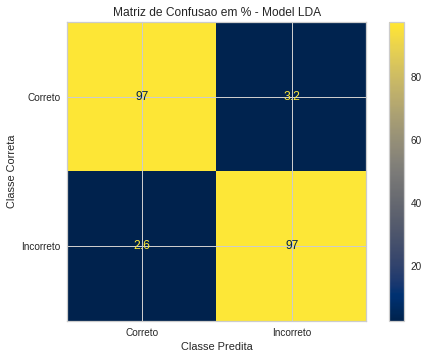

In [49]:
hyper_lda_clf.fit(X_train, y_train)
posture_detector.viz.plot_confusion_matrix(hyper_lda_clf, X_validation, y_validation)
plt.title('Matriz de Confusao em % - Model LDA')
plt.savefig(figure_path+'matriz_de_confusao_percentual_LDA.svg', format='svg')
plt.show()

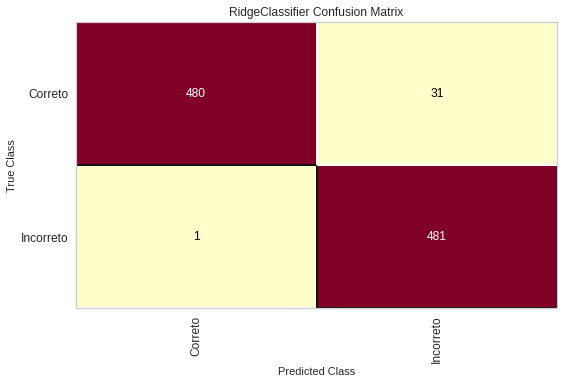

<Figure size 576x396 with 0 Axes>

In [51]:
yellowbrick.classifier.confusion_matrix(
    hyper_ridge_clf,
    X_train, y_train, X_test, y_test,
    classes=['Correto', 'Incorreto']
)
plt.tight_layout()
plt.savefig(figure_path+'matriz_de_confusao_numerica_ridge.svg', format='svg')
plt.show()


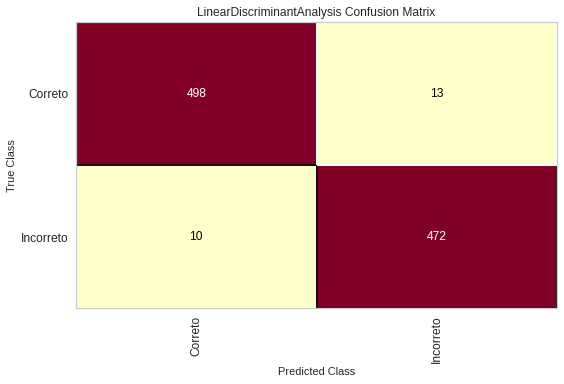

<Figure size 576x396 with 0 Axes>

In [52]:
yellowbrick.classifier.confusion_matrix(
    hyper_lda_clf,
    X_train, y_train, X_test, y_test,
    classes=['Correto', 'Incorreto']
)
plt.tight_layout()
plt.savefig(figure_path+'matriz_de_confusao_numerica_lda.svg', format='svg')
plt.show()

## Plot Decision Boundaries

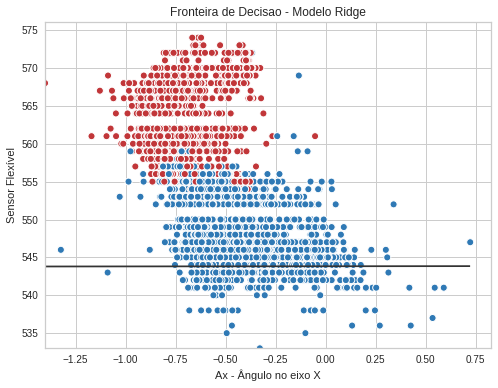

/home/gabriel/dev/posture_detector/posture_detector/viz/plots.py:93: UserWarning: No contour levels were found within the data range.
  ax.contour(xx, yy, probs, levels=[.5], cmap="Greys", vmin=0, vmax=.6)


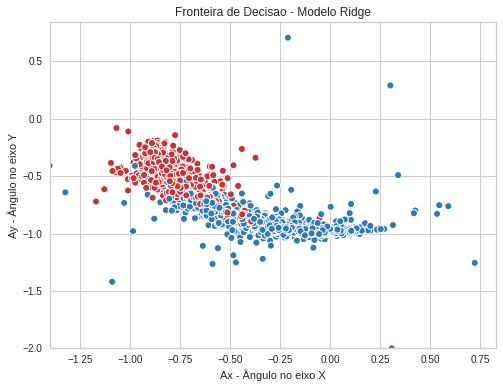

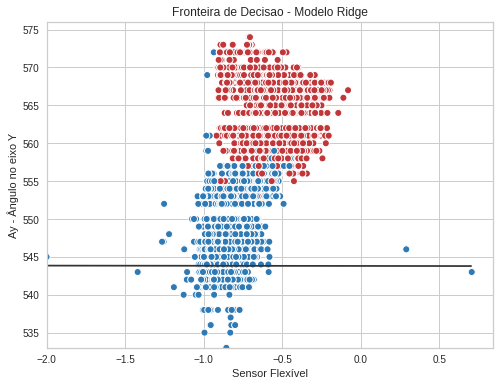

In [71]:
f1 = posture_detector.viz.plot_decision_boundary(
    hyper_ridge_clf,
    X, y,
    columns.Record.Ax,
    columns.Record.Flex,
)
plt.title('Fronteira de Decisao - Modelo Ridge')
plt.ylabel('Sensor Flexível')
plt.xlabel('Ax - Ângulo no eixo X')
plt.savefig(figure_path+'fronteira_de_decisao-modelo_ridge-FlexAx.svg', format='svg')
plt.show()


posture_detector.viz.plot_decision_boundary(
    hyper_ridge_clf,
    X, y,
    columns.Record.Ax,
    columns.Record.Ay,
)
plt.title('Fronteira de Decisao - Modelo Ridge')
plt.ylabel('Ay - Ângulo no eixo Y')
plt.xlabel('Ax - Ângulo no eixo X')
plt.savefig(figure_path+'fronteira_de_decisao-modelo_ridge-Ay_Ax.svg', format='svg')
plt.show()

posture_detector.viz.plot_decision_boundary(
    hyper_ridge_clf,
    X, y,
    columns.Record.Ay,
    columns.Record.Flex,
)
plt.title('Fronteira de Decisao - Modelo Ridge')
plt.ylabel('Ay - Ângulo no eixo Y')
plt.xlabel('Sensor Flexível')
plt.savefig(figure_path+'fronteira_de_decisao-modelo_ridge-Ay_Flex.svg', format='svg')
plt.show()

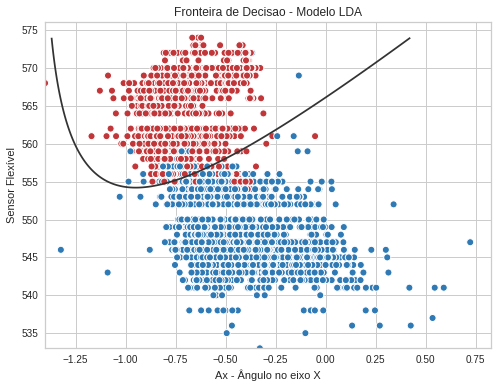

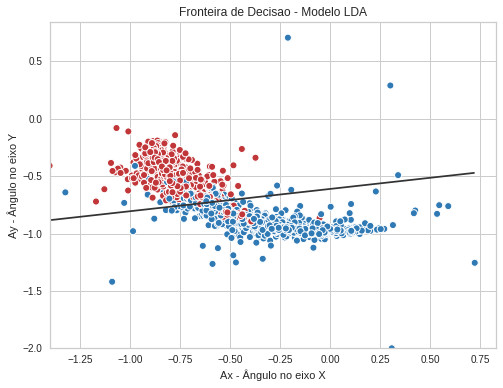

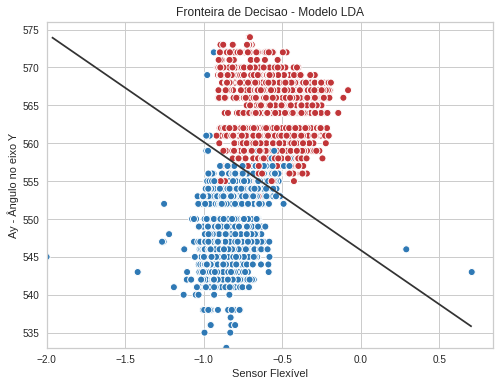

In [70]:
posture_detector.viz.plot_decision_boundary(
    hyper_lda_clf,
    X, y,
    columns.Record.Ax,
    columns.Record.Flex,
)
plt.title('Fronteira de Decisao - Modelo LDA')
plt.ylabel('Sensor Flexível')
plt.xlabel('Ax - Ângulo no eixo X')
plt.savefig(figure_path+'fronteira_de_decisao-modelo_lda-FlexAx.svg', format='svg')
plt.show()

posture_detector.viz.plot_decision_boundary(
    hyper_lda_clf,
    X, y,
    columns.Record.Ax,
    columns.Record.Ay,
)
plt.title('Fronteira de Decisao - Modelo LDA')
plt.ylabel('Ay - Ângulo no eixo Y')
plt.xlabel('Ax - Ângulo no eixo X')
plt.savefig(figure_path+'fronteira_de_decisao-modelo_lda-Ay_Ax.svg', format='svg')
plt.show()

posture_detector.viz.plot_decision_boundary(
    hyper_lda_clf,
    X, y,
    columns.Record.Ay,
    columns.Record.Flex,
)
plt.title('Fronteira de Decisao - Modelo LDA')
plt.ylabel('Ay - Ângulo no eixo Y')
plt.xlabel('Sensor Flexível')
plt.savefig(figure_path+'fronteira_de_decisao-modelo_lda-Ay_Flex.svg', format='svg')
plt.show()

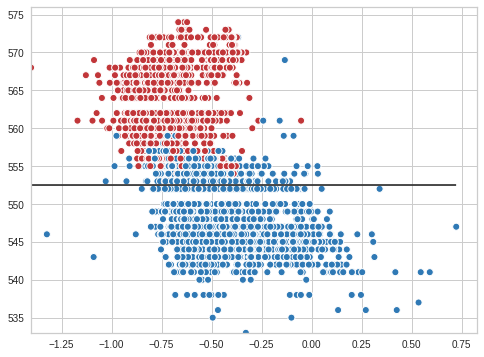

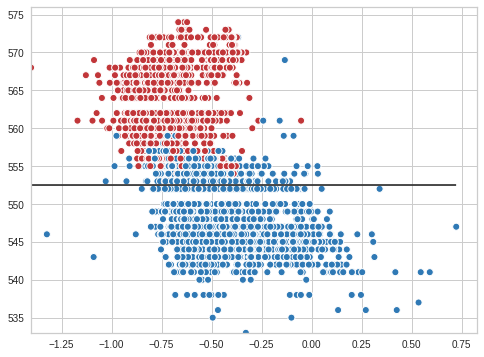

In [45]:
posture_detector.viz.plot_decision_boundary(
    AdaBoostClassifier().fit(X, y),
    X, y,
    columns.Record.Ax,
    columns.Record.Flex,
)

# Serializing models for Reuse

In [37]:

with open('../models/hyper_lda_clf.pkl', 'wb') as file:
    pickle.dump(hyper_lda_clf.fit(X, y), file)
with open('../models/hyper_ridge_clf.pkl', 'wb') as file:
    pickle.dump(hyper_ridge_clf.fit(X, y), file)

/home/gabriel/dev/posture_detector/venv/lib/python3.9/site-packages/yellowbrick/model_selection/importances.py:194: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  warnings.warn(


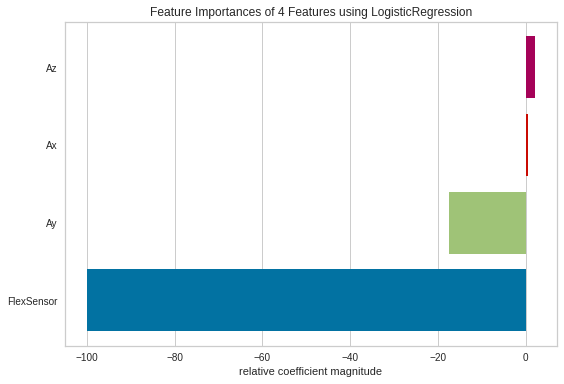

<AxesSubplot:title={'center':'Feature Importances of 4 Features using LogisticRegression'}, xlabel='relative coefficient magnitude'>

In [69]:
yellowbrick.model_selection.FeatureImportances(
    logit.steps[-1][-1], relative=True
).fit(X, y).show()


('clf', LogisticRegression())